In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#visualization functions

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]

def set_grid_and_ticks(ax, leng):
    perc_ticks = np.arange(0, 1, 0.05)
    days_ticks = np.arange(0, leng, 1)
    a = ax.set_xticks(days_ticks)
    a = ax.set_yticks(perc_ticks)
    ax.grid(alpha=0.5)
    return ax

In [3]:
df = pd.read_csv('/users/alonag/lt_surv_c.csv')

In [4]:
df.columns = ['ID','req_day','bad_req_day',
              'bad_req_rate','user_life','days_with_bad_req',
              'active_days','non_active_days','days_since_last_activity']

# add event col - when the last activity was more than a week ago we treat the user as 'dead'
df['event'] = [1 if num > 10 else 0 for num in df['days_since_last_activity']]
# turn this into percentage
df['bad_req_days_rate'] = df['days_with_bad_req'] / df['active_days'] * 100
#clean up
df = df.drop(['ID','bad_req_day','bad_req_rate', 'user_life','non_active_days','active_days'], axis=1)

df.sample(n=10)

,req_day,days_with_bad_req,days_since_last_activity,event,bad_req_days_rate
3325,1.000000,1,24,1,100.0
22472,1.666667,3,11,1,100.0
41650,3.000000,1,23,1,100.0
4182,1.000000,1,24,1,100.0
3942,1.600000,5,18,1,100.0
11503,1.000000,1,3,0,50.0
22598,2.000000,2,22,1,100.0
16678,1.000000,1,23,1,100.0
14322,1.000000,1,23,1,100.0
55536,1.000000,1,24,1,100.0


In [5]:
df.describe()

,req_day,days_with_bad_req,days_since_last_activity,event,bad_req_days_rate
count,59733.000000,59733.000000,59733.000000,59733.000000,59733.000000
mean,1.614195,2.030553,20.985067,0.980162,98.648492
std,1.941858,1.659464,4.564476,0.139446,8.470838
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,20.000000,1.000000,100.000000
50%,1.000000,1.000000,23.000000,1.000000,100.000000
75%,1.571429,2.000000,24.000000,1.000000,100.000000
max,57.640000,14.000000,24.000000,1.000000,100.000000


In [6]:
df['event'].value_counts()

1    58548
0     1185
Name: event, dtype: int64

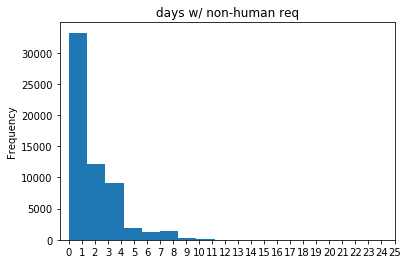

In [7]:
#days in which the user created bad requests

plt.rcParams['figure.figsize'] = [6, 4]

x = df['days_with_bad_req'].plot.hist(title='days w/ non-human req').set_xticks(np.arange(0,26,1))

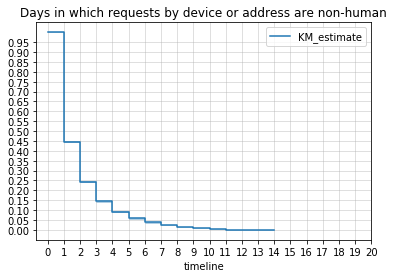

In [8]:
from lifelines import KaplanMeierFitter

kmf_breq = KaplanMeierFitter()

kmf_breq.fit(df['days_with_bad_req'], event_observed=df['event'])

ax = kmf_breq.plot()

plt.rcParams['figure.figsize'] = [6, 5]

x = set_grid_and_ticks(ax, 21).set_title("Days in which requests by device or address are non-human")

In [9]:

print(f'50% of the population will not make bad req after {kmf_breq.percentile(0.50)} days')

print(f'75% of the population will not make bad req after {kmf_breq.percentile(0.25)} days')

print(f'99% of the population will not make bad req after {kmf_breq.percentile(0.01)} days')

print(f'no one will make bad req after {kmf_breq.percentile(0.00)} days')


50% of the population will not make bad req after 1.0 days
75% of the population will not make bad req after 2.0 days
99% of the population will not make bad req after 9.0 days
no one will make bad req after 14.0 days


In [10]:
print(f'Probability that device/address takeover continues after 3 days is: {kmf_breq.predict(3)}')

print(f'Probability that device/address takeover continues after 10 days is: {kmf_breq.predict(10)}')

Probability that device/address takeover continues after 3 days is: 0.14585572331045113
Probability that device/address takeover continues after 10 days is: 0.0033031481126646763


In [19]:
from lifelines import CoxPHFitter

df_reg = df.loc[:,['event','days_with_bad_req','req_day','bad_req_days_rate']]

cp = CoxPHFitter()

cp.fit(df_reg, duration_col='days_with_bad_req', event_col='event')

cp.print_summary()

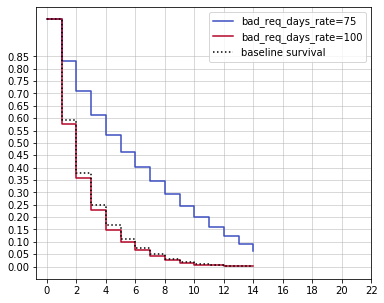

In [12]:
ax = cp.plot_covariate_groups('bad_req_days_rate', [75, 100], cmap='coolwarm')
plt.rcParams['figure.figsize'] = [9, 5]
perc_ticks = np.arange(0, 0.9, 0.05)
days_ticks = np.arange(0, 24, 2)

a = ax.set_xticks(days_ticks)
ax.set_xticks(days_ticks, minor=True)
a = ax.set_yticks(perc_ticks)
ax.set_yticks(perc_ticks, minor=True)
ax.grid(alpha=0.6)


In [13]:
user_a_df = pd.DataFrame(np.array([0,2,1,80]).reshape(1,-1),
                         columns=df_reg.columns)

print(user_a_df)

   event  days_with_bad_req  req_day  bad_req_days_rate
0      0                  2        1                 80


expected # of days: 4.409125549393767 days


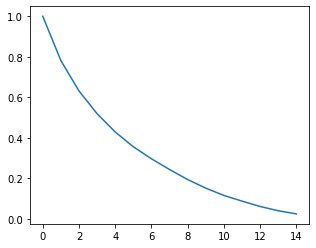

In [14]:
plt.rcParams['figure.figsize'] = [5, 4]

surv = cp.predict_survival_function(user_a_df)
plt.plot(surv)

print(f'expected # of days: {cp.predict_expectation(user_a_df)[0]} days')

In [15]:
user_b_df = pd.DataFrame(np.array([0,2,1,95]).reshape(1,-1), columns=df_reg.columns)
print(user_b_df)

   event  days_with_bad_req  req_day  bad_req_days_rate
0      0                  2        1                 95


expected # of days with bad requests: 2.3962721878729427 days


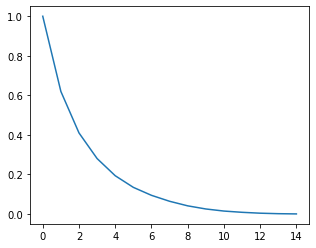

In [16]:
surv = cp.predict_survival_function(user_b_df)
plt.plot(surv)
print(f'expected # of days with bad requests: {cp.predict_expectation(user_b_df)[0]} days')

Text(0, 10, 'User B - 100%')

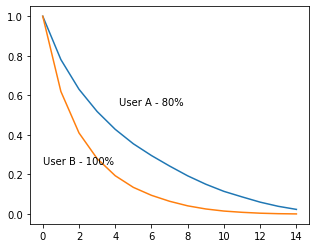

In [31]:
user_a_df = pd.DataFrame(np.array([0,2,1,80]).reshape(1,-1),columns=df_reg.columns)
user_b_df = pd.DataFrame(np.array([0,2,1,95]).reshape(1,-1), columns=df_reg.columns)

surv = cp.predict_survival_function(user_a_df)
plt.plot(surv)
surv = cp.predict_survival_function(user_b_df)
plt.plot(surv)